# 친절한 디퓨전 모델 2-1편: DDPM 실습 텐서플로편


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import plotly.graph_objects as go


[이전 글]()에서 DDPM에 대한 이론을 자세히 알아 봤습니다. 2-1편에서는 텐서플로를 사용해서 DDPM 모델을 직접 만들어봅니다. DDPM을 구현한 많은 참고 자료들이 인터넷에 많으나 이론에 나오는 수식을 1:1 방식으로 간결하게 코드로 매치 시키는 구현은 찾아보기 힘듭니다. DDPM 공식 구현 코드도 간결하고 읽기 좋게 작성된 코드는 아닙니다. 좋은 품질의 이미지를 생성하기 위해 복잡한 네트워크 구조를 사용하고 다양한 실험 옵션을 반영하기 때문인데 이런 코드는 학습용 코드로는 부적합 합니다.

이런 이유로 본 글에서는 최소한 납득할 만한 결과를 보여 주면서도 가능한 간단한 구조로 된 모델을 정의해 사용할 것입니다. 이를 통해 쉽고 빠르게 이론과 실제 코드를 연결하여 이해할 수 있도록 구성했습니다. 더 정교한 이미지를 생성하기 위한 복잡한 네트워크의 적용을 독자 여러분의 몫으로 남겨두도록 하겠습니다.


___

- [주의] 이 글은 [친절한 디퓨전 모델 1편]()의 후속 글로 1편을 읽지 않고 읽으면 정확히 이해가 안될 수 있습니다.

- 본 글에서 사용하는 데이터 셋은 deeplearning.ai에서 제공하는 숏코스 [How Diffusion Models Work](https://www.deeplearning.ai/short-courses/)에서 사용하는 16x16 크기를 가지는 이미지 스프라이트입니다.  

## 데이터 셋 준비

가정 먼저 준비된 데이터 셋 파일을 다운 받습니다.

In [ ]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:00<00:00, 118MB/s]


데이터 파일이 넘파이 어레이로 구성되어 있으므로 `np.load()`로 로딩합니다.

In [ ]:
sprites = np.load('sprites_1788_16x16.npy')

데이터 셋은 넘파이 어레이이며 데이터 셋의 모양과 각 샘플의 최솟값, 최댓값을 확인해보면 개별 샘플은 모양이 (16,16,3)이고 0에서 255값을 가지는 이미지 어레이라는 것을 알 수 있습니다.

In [ ]:
sprites.shape, sprites.min(), sprites.max()

((89400, 16, 16, 3), 0, 255)

이미지의 크기와 채널수를 설정합니다.

In [ ]:
H = 16
W = 16
C = 3

텐서플로는 케라스와 함께 사용할 때 다양한 방식으로 사용할 수 있습니다. 입력과 타겟을 넘파이 어레이 형태로 케라스에 바로 입력할 수도 있고 텐서플로 데이터 셋으로 만들어 입력할 수 도 있습니다. 전자는 데이터의 구조가 간단한 지도학습에 사용하기 알맞고 후자는 데이터에 조작을 가하는 경우 더 유리합니다.

이 모델에서는 입력되는 원본 이미지에 노이즈를 추가하는 작업을 하고 타겟이 이미지가 아니라 노이즈가 되는 등 데이터를 입력할 때 처리해야 하는 작업이 조금 있습니다. 따라서 텐서플로 데이터 셋을 이용해서 작업하는 편이 더 좋습니다. 또 이렇게 해두는 편이 파이토치로 다시 구현할 때 비슷한 구조로 인해 작업이 더 용이하다는 장점도 있습니다. 파이토치 구현은 다음 글로 이어가겠습니다.

`sprites`를 텐서플로 데이터셋으로 변환합니다.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(sprites)
train_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(16, 16, 3), dtype=tf.uint8, name=None)>

만들어진 데이터 셋의 개별 샘플은 모양이 (16,16,3)임을 `TensorSpec`을 통해 알 수 있습니다. 시험삼아 샘플 여섯 개를 가져와서 그려봅니다.

In [ ]:
samples = train_ds.take(6)

반환된 `samples`는 (6,16,16,3)인 텐서이며 이 텐서플로 데이터셋을 for 루프에 걸어서 이미지를 받아올 수 있습니다.

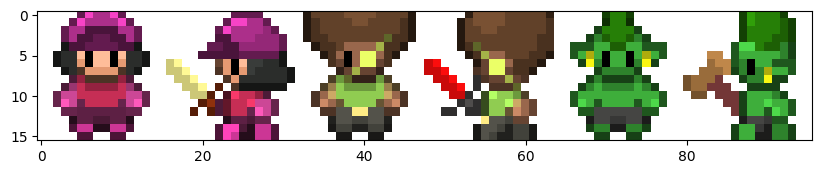

In [ ]:
# (N,H,W,C)
Xs = np.array([X for i, X in enumerate(samples)])

#                    (H,N,W,C)        (H,N*W,C)
images = Xs.transpose(1,0,2,3).reshape(H,-1,C)

fig = plt.figure(figsize=(10,3))
ax = plt.axes()

ax.imshow(images)
plt.show()

샘플의 픽셀이 0에서 255값을 가지기 때문에 이를 -1에서 1로 변환합니다. 데이터 셋에 있는 모든 샘플에 적용할 변환 함수를 만듭니다.

In [ ]:
# 데이터셋에 map함수로 각 샘플에 적용될 변환 함수를 지정
train_cast_ds = train_ds.map(
    lambda image: (tf.cast(image, tf.float32)/255.0) * 2 - 1
)

변환이 잘 적용되는지 확인하기 위해 다시 여섯 개 샘플을 가져오고 이번에는 그리기 전에 역변환을 해서 그려보겠습니다.

In [ ]:
samples = train_cast_ds.take(6)

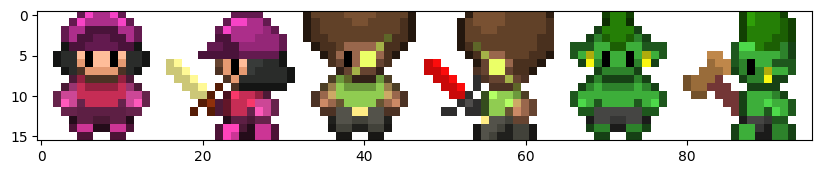

In [ ]:
# (N,H,W,C)
Xs = np.array([X for i, X in enumerate(samples)])

#                    (H,N,W,C)        (H,N*W,C)
images = Xs.transpose(1,0,2,3).reshape(H,-1,C)

# -1~1을 0~255로 되돌림
imgs = ((images + 1) / 2 * 255).astype(np.uint8)

fig = plt.figure(figsize=(10,3))
ax = plt.axes()

ax.imshow(imgs)
plt.show()

정상적으로 그려지는걸 보니 변환과 역변환이 잘 적용되는것 같습니다.

### 노이즈 스케쥴러 정의 및 적용

식(4)에 의해 $\mathbf{x}_t = \sqrt{\bar{\alpha}_t } \mathbf{x}_0, + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}$이므로 임의의 시간단계 $t$에 대한 $\mathbf{x}_t$를 바로 만들기 위해 모든 시간 단계에 대해서 $\beta_t$, $\alpha_t$, $\bar\alpha_t$를 계산합니다.

In [ ]:
# beta는 DDPM 원문의 설정을 따르고
beta_1 = 1e-4
beta_T = 0.02
# 시간 단계는 deeplearning.ai에서 제공하는 숏코스 How Diffusion Models Work의 설정을 따름
T = 500

# beta는 첨자 1부터 T까지 사용하기 위해 제일 앞에 더미 데이터 tf.constant([0.])를 추가하여 만듬
beta = tf.concat([tf.constant([0.], dtype=tf.float32), tf.linspace(beta_1, beta_T, T)], axis=0)
alpha = 1 - beta

# np.exp와 np.cumsum, np.log에 대응하는 TensorFlow 연산을 사용
alpha_bar = tf.exp(tf.cumsum(tf.math.log(alpha)))

beta[1], beta[-1], alpha[1], alpha[-1], alpha_bar[1], alpha_bar[-1]

(<tf.Tensor: shape=(), dtype=float32, numpy=1e-04>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.02>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9999>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9999>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0063527143>)


계산된 $\alpha_t$, $\bar\alpha_t$로 $\sqrt{\bar{\alpha}_t}$, $\sqrt{1-\bar{\alpha}_t}$를 그려보면 시간 단계가 증가할 수 록 $\mathbf{x}_t$는 가우시안 노이즈가 되는 것을 알 수 있습니다.

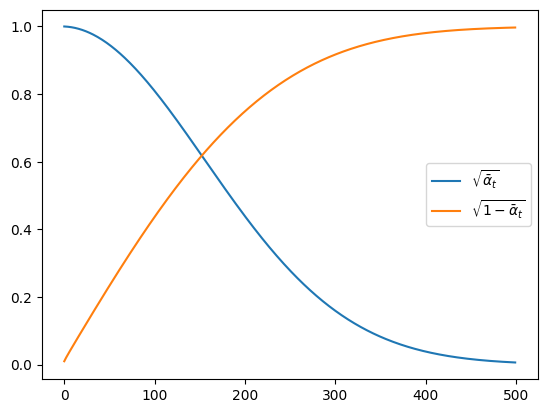

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(alpha_bar[1:].numpy(), label=r"$\sqrt{\bar{\alpha}_t}$")
ax.plot(tf.sqrt(1-alpha_bar[1:]).numpy(), label=r"$\sqrt{1-\bar{\alpha}_t}$")

plt.legend()
plt.show()

$\mathbf{x}_t = \sqrt{\bar{\alpha}_t } \mathbf{x}_0, + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}$로 `x`로 부터 `x_t`를 계산하는 함수를 작성합니다. 이 함수는 데이터 셋에 있는 개별 샘플을 `x`로 입력받아 노이즈가 추가된 `x_t`를 반환합니다.

In [ ]:
def perturb_x(x, t, eps):
    # x: (H, W, C), 배치로 처리되지 않음

    return tf.sqrt(alpha_bar[t]) * x + tf.sqrt(1 - alpha_bar[t]) * eps

`perturb_x()`이용해서 텐서플로 데이터 셋에 적용할 노이즈 적용함수를 작성합니다.

In [ ]:
def apply_perturb(x_0):
    # sample time step t
    t = tf.random.uniform(shape=[], minval=1, maxval=T+1, dtype=tf.int32)

    # make x_t
    eps = tf.random.normal(shape=x_0.shape)
    x_t = perturb_x(x_0, t, eps)

    # 원본 x_0, 노이즈낀 이미지 x_t와 타겟 eps, 시간단계 t 반환
    return x_0, x_t, eps, t


이 함수를 데이터 셋에 적용시키면 텐서플로 데이터 셋은 샘플을 리턴하기 직전에 이 함수를 작동시켜 하나의 샘플에 대해서 $(\mathbf{x}_0, \mathbf{x}_t, \boldsymbol{\epsilon}, t)$를 리턴헤게 됩니다.

In [ ]:
train_cast_perturb_ds = train_cast_ds.map(apply_perturb)

이제 다시 여섯개 데이터를 가져오고 그림을 그려봅니다.

In [ ]:
samples = train_cast_perturb_ds.take(6)

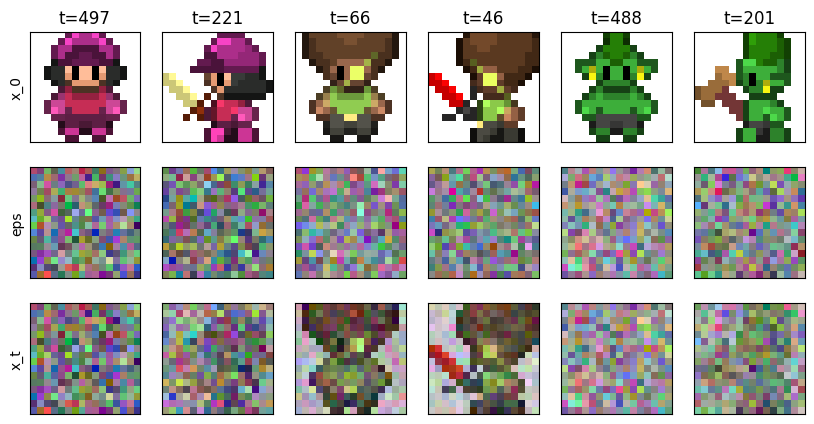

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), nrows=3, ncols=6)

# 여기 for문을 돌면서 실제 map()이 적용되고 구체적인 데이터가 반환됨
for i, (x_0, x_t, eps, t) in enumerate(samples):
    x_0 = x_0.numpy()
    x_t = x_t.numpy()
    eps = eps.numpy()

    x_0 = ((x_0 - x_0.min()) / (x_0.max() - x_0.min())).clip(0,1)
    axs[0][i].imshow(x_0)
    axs[0][i].set_title(f"t={t.numpy()}")
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])

    eps = ((eps - eps.min()) / (eps.max() - eps.min())).clip(0,1)
    axs[1][i].imshow(eps)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])

    x_t = ((x_t - x_t.min()) / (x_t.max() - x_t.min())).clip(0,1)
    axs[2][i].imshow(x_t)
    axs[2][i].set_xticks([])
    axs[2][i].set_yticks([])

    if i == 0:
        axs[0][i].set_ylabel('x_0')
        axs[1][i].set_ylabel('eps')
        axs[2][i].set_ylabel('x_t')

plt.show()

그림을 확인해보면 샘플 중 앞 여섯개에 임의의 시간 단계에 대한 노이즈가 적용되는 것을 알 수 있습니다. 첫 행은 원본 이미지, 둘째 행은 적용될 노이즈, 셋째 행은 노이즈가 적용된 모습을 나타냅니다. 시간 단계가 작을 수록 원본 이미지가 남아있고 200이 넘어가면 거의 알아볼 수 없게 될 것입니다.

만들어진 데이터 셋에 셔플과 배치사이즈를 적용합니다.

In [ ]:
m = 64

train_cast_perturb_ds_batch = train_cast_perturb_ds.shuffle(1000).batch(m)

최종적으로 완성된 `train_cast_perturb_ds_batch`를 `for`문에 적용하여 한 배치 만큼 데이터를 가져와 봅니다.

In [ ]:
for i, X in enumerate(train_cast_perturb_ds_batch):
    print(X[0].shape, X[1].shape, X[2].shape, X[3])
    break

(64, 16, 16, 3) (64, 16, 16, 3) (64, 16, 16, 3) tf.Tensor(
[421  20  13 374  41 125 362 307 294 420 193  18 270 190  73 490  22 217
 346 127 445  15 184 187 288 147 261 234 371 244 173  21 364 230 258  66
 162 303 103 192 213 441 211 385 482 100  42 374 288 163 472 414 150 457
 121 377 149 207 285 216  39  33  80 412], shape=(64,), dtype=int32)


순서대로 원본 이미지, 노이즈가 추가된 이미지, 노이즈가 64개 반환되고 마지막으로 각 시간 단계가 1차원 텐서로 반환되는것을 확인할 수 있습니다.

## 모델 만들기


<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/alg_training.png" alt="ddpm figure2 mod"  width="700" style="border:2px solid black;">

정의한 모델을 학습시키기 위해선 알고리즘 1을 따라야 합니다. 케라스에서 제공하는 `fit()`의 잇점을 그대로 사용하면서 사용자 정의 학습 스탭을 적용시키기 위해 `tf.keras.Model`을 상속받고 학습 스탭만 재정의 하도록 합니다.

아래 코드는 [Model.fit의 동작 사용자 정의하기](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit?hl=ko)에서 제공하는 뼈대코드를 약간 수정하여 재사용한 것입니다.

In [ ]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # data는 tf.data.Datset에서 반환하는 배치이므로
        # x_0, x_t, eps, t로 언팩킹
        x_0, x_t, eps, t = data

        # 타겟을 노이즈로 설정
        target = eps

        with tf.GradientTape() as tape:
            # Forward pass
            # 시간 단계 숫자 t는 Dense층으로 입력되기 때문에 1차원 벡터 [t]로 변환
            pred = self( [x_t, tf.reshape(t, (-1,1))], training=True)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(target, pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(target, pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

이제 모델을 정의 합니다. 가능하다면 (16,16,3) 크기의 이미지를 (768,) 크기의 벡터로 펼친 다음 완전 연결 네트워크로만 구성하고 싶었지만 실험 결과 이런 MLP 구조로는 의미있는 결과를 만들 수 없었습니다. 따라서 conv 레이어를 가지는 간단한 네트워크를 사용합니다. 원문에는 Unet 구조를 사용한다고 되어있지만 Unet도 복잡하기 때문에 Unet 특징이 약간 들어있는 아래 그림과 같은 네트워크를 사용하겠습니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/model.png" alt="keras model" width="1000" style="border:2px solid black;">

네트워크 구조는 매우 간단하여 그림과 아래 코드를 함께 보면 금방 이해가 갈 것입니다. 네트워크의 특징을 다음으로 요약할 수 있습니다.

- 이미지에 Conv레이어를 몇번 적용하여 만들어진 특징 맵과 시간 단계에 Dense 레이어를 몇번 적용한 임베딩 벡터를 중간쯤에서 더하여 두 입력을 모두 반영하는 특징 맵을 만듭니다.

- 특징 맵을 다시 이미지 모양으로 디코딩할 때 인코딩 과정에서 만들어 둔 특징 맵과 연결시키는 스킵 커넥션 구조를 한번 사용합니다.

In [ ]:
input_t = tf.keras.Input(shape=(1), name="time_input")
t = tf.keras.layers.Dense(32, activation='relu')(input_t)
t = tf.keras.layers.Dense(64, activation='relu')(t)
t = tf.keras.layers.Reshape((1,1,64))(t)

input_image = tf.keras.Input(shape=(H,W,C), name="image_input")

# encoder
x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='gelu')(input_image)
x_32 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='gelu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_32)
x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='gelu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Add()([x, t])
x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='gelu')(x)

# decoder
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='gelu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='gelu', padding='same')(x)
# x와 x_32를 ch방향으로 concat
x = tf.keras.layers.Concatenate(axis=-1)([x, x_32])
output = tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='linear')(x)

# 정의된 입력과 출력으로 앞서 정의한 CustomModel을 생성
model = CustomModel(inputs=[input_image, input_t], outputs=output)

모델 서머리를 출력하고 구조를 그려 의도된 형태로 만들어졌는지 확인합니다.

In [ ]:
model.summary()

Model: "custom_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['image_input[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                       

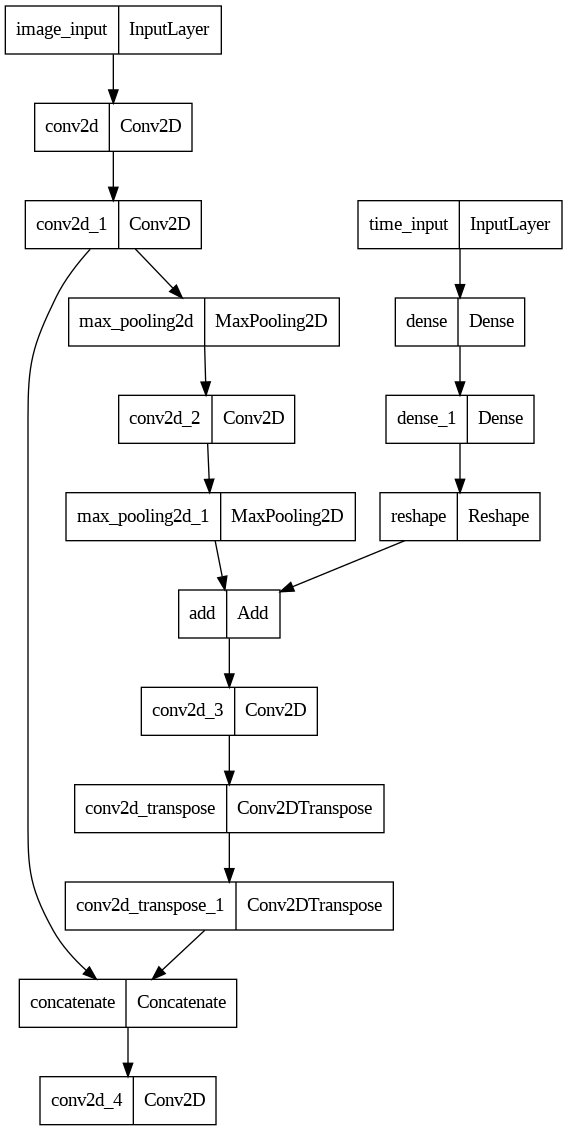

In [ ]:
tf.keras.utils.plot_model(model)

모델을 완성했으면 앞서 만들어둔 데이터 셋을 이용해 포워드 테스트를 해봐야 합니다. 배치 사이즈 64이므로 한 배치를 네트워크에 입력하면 출력으로 (64,16,16,3)이 나와야 합니다.

In [ ]:
# forward test
for sample in train_cast_perturb_ds_batch.take(1):
    x_0, x_t, eps, t = sample
    output = model( [x_t, tf.reshape(t, (-1,1))]  )

output.shape

TensorShape([64, 16, 16, 3])

포워드 테스트가 성공했으므로 이제 학습 시키는 일만 남았습니다.

## 학습



$$
L_{\text{simple}}(\theta) := \mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \left\lVert \boldsymbol{\epsilon}- \boldsymbol{\epsilon}_\theta(\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}, t) \right\rVert^2_2 \right] \tag{14}
$$

위 손실 함수는 모든 샘플과 시간 단계에 대해서 MSE 손실 함수를 사용한다는 것을 의미합니다. 손실 함수를 식(14)처럼 MSE로 설정하고 적당한 옵티마이저를 지정하여 모델을 컴파일 합니다.

In [ ]:
loss_func = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=['mae'])

학습을 시작합니다.

In [ ]:
epochs = 30

history = model.fit(train_cast_perturb_ds_batch, epochs=epochs, shuffle=True)

Epoch 1/30
1397/1397 [==============================] - 23s 12ms/step - loss: 0.4016 - mae: 0.4605
Epoch 2/30
1397/1397 [==============================] - 18s 13ms/step - loss: 0.2577 - mae: 0.3614
Epoch 3/30
1397/1397 [==============================] - 17s 12ms/step - loss: 0.2136 - mae: 0.3204
Epoch 4/30
1397/1397 [==============================] - 23s 16ms/step - loss: 0.1926 - mae: 0.3004
Epoch 5/30
1397/1397 [==============================] - 18s 13ms/step - loss: 0.1817 - mae: 0.2890
Epoch 6/30
1397/1397 [==============================] - 18s 13ms/step - loss: 0.1730 - mae: 0.2797
Epoch 7/30
1397/1397 [==============================] - 19s 13ms/step - loss: 0.1641 - mae: 0.2704
Epoch 8/30
1397/1397 [==============================] - 19s 14ms/step - loss: 0.1610 - mae: 0.2663
Epoch 9/30
1397/1397 [==============================] - 21s 15ms/step - loss: 0.1543 - mae: 0.2591
Epoch 10/30
1397/1397 [==============================] - 19s 13ms/step - loss: 0.1503 - mae: 0.2545
Epoch 11/

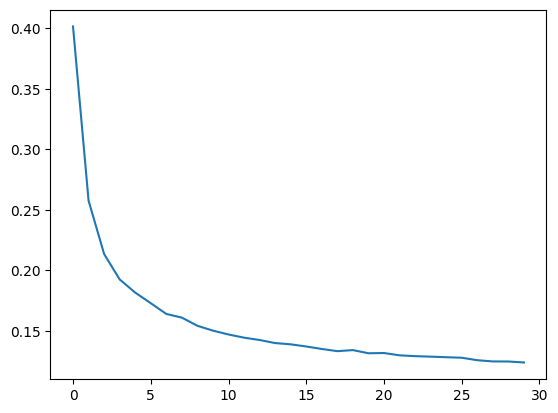

In [ ]:
plt.plot(history.history['loss'])
plt.show()

## 샘플링

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/alg_sampling.png" alt="ddpm figure2 mod"  width="700" style="border:2px solid black;">

학습된 모델을 이용해서 샘플링 알고리즘을 따라 모든 시간 단계에 대한 샘플을 샘플링합니다.

In [ ]:
# 샘플링 단계동안 생성된 이미지를 일정 간격마다 저장할 리스트를 준비
interval = 20 # 20 시간 단계마다 한장씩 생성 결과 기록
X = [] # 생성 이미지 저장
saved_frame = [] # 이미지를 저장한 시간 단계를 저장
N = 5 # 모델에 입력할 샘플 개수

# 최초 노이즈 샘플링
x = tf.random.normal(shape=(N, H, W, C))

for t in range(T, 0, -1):
    if t > 1:
        z = tf.random.normal(shape=(N,H,W,C))
    else:
        z = tf.zeros((N,H,W,C))

    eps_theta = model([x, tf.reshape(t, (1,1))])
    x = (1 / tf.sqrt(alpha[t])) * (x - ((1-alpha[t])/tf.sqrt(1-alpha_bar[t]))*eps_theta) + tf.sqrt(beta[t])*z

    if (T - t) % interval == 0  or t == 1:
        # 현재 시간 단계로 부터 생성되는 t-1번째 이미지를 저장
        saved_frame.append(t)
        x_np = x.numpy()

        x_np = x_np.transpose(1,0,2,3).reshape(H,-1,C)
        x_np = ((x_np - x_np.min()) / (x_np.max() - x_np.min())).clip(0,1)
        X.append( x_np*255.0 ) # 0 ~ 1 -> 0 ~ 255

X = np.array(X, dtype=np.uint8)

샘플링 과정동안 수집한 이미지를 애니메이션으로 표현합니다.

`plotly`로 애니메이션을 표시하는 예제 코드는 이곳 [https://plotly.com/python/animations/](https://plotly.com/python/animations/)과 이곳 [https://plotly.com/python/imshow/](https://plotly.com/python/imshow/)을 참고 하여 작성하였습니다.

In [ ]:
fig = go.Figure(
    data = [ go.Image(z=X[0]) ],
    layout = go.Layout(
        # title="Generated image",
        autosize = False,
        width = 800, height = 400,
        margin = dict(l=0, r=0, b=0, t=30),
        xaxis = {"title": f"Generated Image: x_{T-1}"},
        updatemenus = [
            dict(
                type="buttons",
                buttons=[
                    # play button
                    dict(
                        label="Play", method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 50, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 50, "easing": "quadratic-in-out"}
                            }
                        ]
                    ),
                    # pause button
                    dict(
                        label="Pause", method="animate",
                        args=[
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }
                        ]
                    )
                ],
                direction="left", pad={"r": 10, "t": 87}, showactive=False,
                x=0.1, xanchor="right", y=0, yanchor="top"
            )
        ], # updatemenus = [
    ), # layout = go.Layout(
    frames = [
        {
            'data':[go.Image(z=X[t])],
            'name': t,
            'layout': {
                'xaxis': {'title': f"Generated Image: x_{saved_frame[t]-1}"}
            }
        } for t in range(len(X))
    ]
)

################################################################################
# 슬라이더 처리
sliders_dict = {
    "active": 0, "yanchor": "top", "xanchor": "left",
    "currentvalue": {
        "font": {"size": 15}, "prefix": "input time:",
        "visible": True, "xanchor": "right"
    },
    "transition": {"duration": 100, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9, "x": 0.1, "y": 0,
    "steps": []
}

for t in range(len(X)):
    slider_step = {
        "label": f"{saved_frame[t]}", "method": "animate",
        "args": [
            [t], # frame 이름과 일치해야 연결됨
            {
                "frame": {"duration": 100, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 100}
            }
        ],
    }

    sliders_dict["steps"].append(slider_step)

fig["layout"]["sliders"] = [sliders_dict]
################################################################################

fig.show()

위 그림에서 play를 누르거나 슬라이드 바를 이동 시키면 시간 단계에 따라 노이즈가 제거되는 이미지를 확인할 수 있습니다. 완전히 깨끗하고 정교하게 노이즈가 제거되진 않지만 무작위 노이즈로부터 게임 아이템과 캐릭터 처럼 생긴 물체들이 약 200단계에서부터 서서히 생겨나는것을 확인할 수 있습니다!

간단한 네트워크로 충분히 납득할만한 결과를 생성할 수 있었습니다. 이제 여러분들이 네트워크를 더 정교하게 다듬어 생생한 캐릭터 이미지를 생성하시기 바랍니다.

2-2편은 동일한 내용의 파이토치 구현편입니다.

